the goal
how to do GPU-Accelerated numerical computing from Python using the Numba Python compiler in combination with the CuPy GPU array library

tutorial from 
https://github.com/numba/pydata-amsterdam2019-numba

## What is CuPy?

Simply put: CuPy is NumPy, but for the GPU.
- Preferred Networks created CuPy
- deep learning library: Chainer

CuPy offers 3 basic things
- a multidimensional array object, but stored in GPU memory.
- A ufunc system that follows broadcast rules, but executes in parallel on the GPU.
- A large librayr of array functions already implemented with CUDA

In [1]:
import numpy as np
import cupy  as cp

In [2]:
ary = cp.arange(10).reshape((2,5))
print(repr(ary))
print(ary.dtype)
print(ary.shape)
print(ary.strides)

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])
int64
(2, 5)
(40, 8)


default GPU (device 0).

In [3]:
ary.device

<CUDA Device 0>

we can move data from teh CPU to the GPU using the cp.asarray() function:

Note that when we print the contents of a GPU array, CuPy is copying the data from the GPU back to the CPU so it can print the results.

In [5]:
ary_cpu = np.arange(10)
ary_gpu = cp.asarray(ary_cpu)
print("cpu", ary_cpu)
print("gpu", ary_gpu)
print(ary_gpu.device)

cpu [0 1 2 3 4 5 6 7 8 9]
gpu [0 1 2 3 4 5 6 7 8 9]
<CUDA Device 0>


If we are done with tedata on the GPU, we can convert it back to a Numpy array on teh CPU with the cp.asnumpy() function

In [6]:
ary_cpu_returned = cp.asnumpy(ary_gpu)
print(repr(ary_cpu_returned))
print(type(ary_cpu_returned))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
<class 'numpy.ndarray'>


## GPU Array Math

In [7]:
print(ary_gpu * 2)
print(cp.exp(-0.5 * ary_gpu**2))
print(cp.linalg.norm(ary_gpu))
print(cp.random.normal(loc=5, scale=2.0, size=10))

[ 0  2  4  6  8 10 12 14 16 18]
[1.00000000e+00 6.06530660e-01 1.35335283e-01 1.11089965e-02
 3.35462628e-04 3.72665317e-06 1.52299797e-08 2.28973485e-11
 1.26641655e-14 2.57675711e-18]
16.881943016134134
[7.09472168 4.5979743  4.47609303 2.70153881 9.46901103 9.04566367
 2.7932202  3.95097844 7.09259102 6.44352669]


## When would I want Numba on the GPU

similar to Numpy, Numba can be useful to use with CuPy when you want to
- combine several operations together for greater efficiency
- implement custom algorithms that are not easily described by combining CuPy functions.

Numba's compiler pipeline for transforming Python functions to machine code can be used to generate CUDA functions which can be used standalone or with CuPy. There are two basic approaches supported by Numba:
- 1. ufuncs/gufuncs (subject of the rest of this notebook)
- 2. CUDA Python kernels (subject of next notebook)

## Making new ufuncs for the GPU

implement scalar function of all the inputs, and Numba will figure out the broadcast rules for you. Generating a ufunc that uses CUDA requires giving an explicit type signature and setting the target atribute.

In [23]:
import numpy as np
import scipy.stats as stats
from numba import vectorize
import math

In [9]:
@vectorize(['int64(int64, int64)'], target='cuda')
def add_ufunc(x, y):
    return x+y

In [12]:
a = np.array([1, 2, 3, 4])
b = np.array([10,20,30,40])
b_col = b[:, np.newaxis]
c = np.arange(4*4).reshape((4,4))

print('a+b:\n', add_ufunc(a, b))
print()
print("b_col + c:\n", add_ufunc(b_col, c))

a+b:
 [11 22 33 44]

b_col + c:
 [[10 11 12 13]
 [24 25 26 27]
 [38 39 40 41]
 [52 53 54 55]]


A lot of things just happend! Numba automatically:
- Compiled a CUDA kernel to execute the ufunc operation in parallel over all teh input elements.
- Allocated GPU memory for the inputs and the outputs
- Copied the input date to the GPU.
- Executed the CUDA kernel with the correct kernel dimensions given the input sizes
- Copied the result back from teh GPU to the CPU.
- Returned the result as a NumPy array on the host.

In [13]:
%timeit np.add(b_col, c) # Numpy on CPU

1 µs ± 2.65 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [14]:
%timeit add_ufunc(b_col, c) # Numpy on GPU

1.07 ms ± 4.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


My own experiment: what if I use CuPy to avoid the copy between CPU and GPU

In [18]:
a_gpu     = cp.asarray(a) 
b_col_gpu = cp.asarray(b_col)
c_gpu     = cp.asarray(c)

In [19]:
%timeit add_ufunc(b_col_gpu, c_gpu)

1.14 ms ± 2.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


No: it does not improve anything

GPU is a lot slower
- our inputs are too small
- our calculation is too simple
- we copy the data to and from the GPU
- our data types are larger than necessary

Let's try an example that is faster on teh GPU:

In [16]:
SQRT_2PI = np.float32((2*math.pi)**0.5)
print(SQRT_2PI)

2.5066283


In [20]:
@vectorize(['float32(float32, float32, float32)'], target = "cuda")
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma'''
    return math.exp(-0.5 * ((x-mean)/sigma)**2) / (sigma * SQRT_2PI)

In [27]:
x = np.random.uniform(-3, 3, size = 100000).astype(np.float32)
mean  = np.float32(0.0)
sigma = np.float32(1.0)

### quick test
print(gaussian_pdf(x[0], 0.0, 1.0))

norm_pdf = stats.norm
print(norm_pdf.pdf(x[0], loc=0.0, scale=1.0))

[0.05394763]
0.05394762515703378


In [30]:
res1 = norm_pdf.pdf(x, loc=0.0, scale=1.0)
res2 = gaussian_pdf(x, 0.0, 1.0)
np.testing.assert_almost_equal(res1, res2)

In [31]:
%timeit norm_pdf.pdf(x, loc=0.0, scale=1.0)

2.87 ms ± 6.67 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
%timeit gaussian_pdf(x, 0.0, 1.0)

1.59 ms ± 5.59 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## CUDA Device Functions

Ufuncs are great, but you should not have to cram all of your logic into a single function body.

You can also create normal functions that are only called from other functions running on teh GPU

These are similar to CUDA C functions defined with `__device__`

In [40]:
import numpy as np
import scipy.stats as stats
from   numba import jit, vectorize, cuda
import math

In [49]:
@cuda.jit(device=True)
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y

@vectorize(['float32(float32, float32, float32, float32)'], target = "cuda")
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1)
    x2, y2 = polar_to_cartesian(rho2, theta2)
    return ((x1-x2)**2+(y1-y2)**2)**0.5

In [56]:
n = 1000000

rho1 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
rho2 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)

theta1 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)
theta2 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)

In [57]:
polar_distance(rho1, theta1, rho2, theta2)

array([2.1792142 , 2.366815  , 0.4857281 , ..., 1.6380883 , 0.59268856,
       2.2841072 ], dtype=float32)

Note:
- CUDA compiler aggressively inlines device functions => no overhead for function calls
- tupel returned by polar_distance is not actually created as a Python object, but represented temporarily as a struct, which is then optimized away by the compiler

compare this to doing the same thing on the CPU, still using Numba:

In [58]:
@jit
def polar_to_cartesian_cpu(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y

@vectorize(['float32(float32, float32, float32, float32)']) # default target is CPU
def polar_distance_cpu(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian_cpu(rho1, theta1)
    x2, y2 = polar_to_cartesian_cpu(rho2, theta2)
    return ((x1-x2)**2+(y1-y2)**2)**0.5

In [59]:
np.testing.assert_allclose(
    polar_distance(rho1, theta1, rho2, theta2),
    polar_distance_cpu(rho1, theta1, rho2, theta2),
    rtol=1e-7, atol=5e-7)

In [60]:
%timeit polar_distance(rho1, theta1, rho2, theta2)

5.89 ms ± 51.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [61]:
%timeit polar_distance_cpu(rho1, theta1, rho2, theta2)

17.2 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Allowed Python on the GPU

Compared to Numba on teh CPU, Numba on the GPU has more limitations

Supported:
- if/elif/else
- while and for loops
- basic math operators
- Selected functions from teh math and cmath modules
- Tuples

## Exercise

Let's build a "zero suppression" funciton: a common operation when working with waveforms is to force all samples values below a vertain absolute magnitude to be zero, as a way to eliminate low amplitude noise. Let's make some sample data:

In [62]:
from matplotlib import pyplot as plt

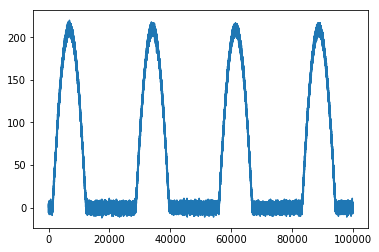

In [65]:
n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n/23)) - 0.3, 0)
waveform = (pulses * 300 + noise).astype(np.int16)
plt.plot(waveform)

In [66]:
@vectorize(["int16(int16, int16)"], target="cuda")
def zero_suppress(waveform_value, threshold):
    ### replace this implementation with yours
    result = waveform_value
    return result

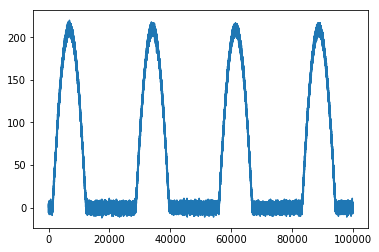

In [67]:
# the noise on teh baseline should disappear when zero_suppress is implemented properly
plt.plot(zero_suppress(waveform, 15.0))

My Answer:

In [68]:
@vectorize(["int16(int16, int16)"], target="cuda")
def zero_suppress(waveform_value, threshold):
    ### replace this implementation with yours
    if waveform_value < threshold:
        return 0
    else:
        return waveform_value 

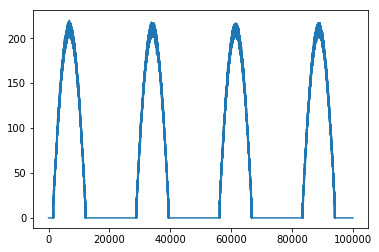

In [69]:
# the noise on teh baseline should disappear when zero_suppress is implemented properly
plt.plot(zero_suppress(waveform, 15.0))